# **Data Loading**
all the loading, preprossing including data pixel change and scc dataupload was done by Yanqi Su

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import normalize

# Define the paths to the AI and Human image directories
ai_path = '/content/drive/MyDrive/BA865 Project/Image folder/ai_images_75'
human_path = '/content/drive/MyDrive/BA865 Project/Image folder/human_images_75_1'

# Function to load images from a directory and convert them to an array
def load_images_from_folder(folder_path, target_size=(75, 75)):
    image_data = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):  # check if the file is an image
            img_path = os.path.join(folder_path, filename)
            img = load_img(img_path, target_size=target_size)  # Load image and resize it
            img_array = img_to_array(img)  # Convert the image to an array
            image_data.append(img_array)
    return np.array(image_data)

# Load AI and Human images
ai_images = load_images_from_folder(ai_path)
human_images = load_images_from_folder(human_path)


In [ ]:

# Normalize the image data
ai_images = normalize(ai_images, axis=1)
human_images = normalize(human_images, axis=1)

# Create a dictionary with labels and data
data = {
    'AI': ai_images,
    'Human': human_images
}

# Optionally, check shapes of the arrays
print('AI images shape:', ai_images.shape)
print('Human images shape:', human_images.shape)

AI images shape: (6300, 75, 75, 3)
Human images shape: (6300, 75, 75, 3)


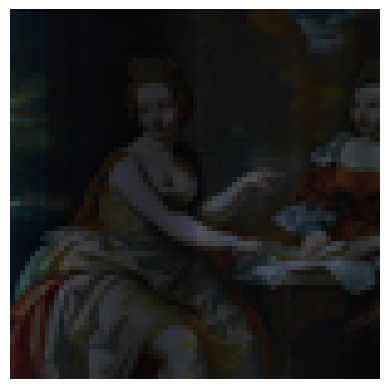

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(ai_images[1])  # Display the first image
plt.axis('off')           # Hide the axis
plt.show()

# **Train Validation Test split**

In [ ]:
from sklearn.model_selection import train_test_split

# Function to split data
def split_data(images, test_size=0.3):
    # Split into train and remaining first
    train, remaining = train_test_split(images, test_size=test_size, random_state=42)
    # Split remaining into validation and test
    validation, test = train_test_split(remaining, test_size=1/3, random_state=42)
    return train, validation, test

# Split AI and Human images separately
train_ai, val_ai, test_ai = split_data(ai_images)
train_human, val_human, test_human = split_data(human_images)

# Combine the datasets back into train, validation, and test sets
train_images = np.vstack((train_ai, train_human))
val_images = np.vstack((val_ai, val_human))
test_images = np.vstack((test_ai, test_human))

# Create labels for each
train_labels = np.array(['AI'] * len(train_ai) + ['Human'] * len(train_human))
val_labels = np.array(['AI'] * len(val_ai) + ['Human'] * len(val_human))
test_labels = np.array(['AI'] * len(test_ai) + ['Human'] * len(test_human))

# Print the shapes to verify
print('Train images shape:', train_images.shape)
print('Validation images shape:', val_images.shape)
print('Test images shape:', test_images.shape)
print('Train labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

Train images shape: (8820, 75, 75, 3)
Validation images shape: (2520, 75, 75, 3)
Test images shape: (1260, 75, 75, 3)
Train labels shape: (8820,)
Validation labels shape: (2520,)
Test labels shape: (1260,)


In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
# Encode labels into integers
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Convert labels to one-hot encoding
train_labels_one_hot = to_categorical(train_labels_encoded)
val_labels_one_hot = to_categorical(val_labels_encoded)
test_labels_one_hot = to_categorical(test_labels_encoded)

# **Logistic Regression**
Logistic regression was done Katniss Zhu

In [ ]:
ai_path = '/content/drive/MyDrive/BA865 Project/Image folder/ai_images_75'
human_path = '/content/drive/MyDrive/BA865 Project/Image folder/human_images_75_1'

from PIL import Image
from torchvision import transforms
import os
import torch

def load_images_from_folder(folder_path, target_size=(75, 75)):
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image_tensors = []
    filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path).convert('RGB')
            img_tensor = transform(img)
            image_tensors.append(img_tensor)
            filenames.append(filename)

    return torch.stack(image_tensors), filenames

ai_images_for_log, ai_filenames = load_images_from_folder(ai_path)
human_images_for_log, human_filenames = load_images_from_folder(human_path)



In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split

class ImageDataset(Dataset):
    def __init__(self, images, labels, filenames):
        self.images = images
        self.labels = labels
        self.filenames = filenames

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx], self.filenames[idx]

all_images = torch.cat((ai_images_for_log, human_images_for_log), dim=0)
all_labels = torch.cat((torch.zeros(len(ai_images_for_log)), torch.ones(len(human_images_for_log))), dim=0)
all_filenames = ai_filenames + human_filenames

full_dataset = ImageDataset(all_images, all_labels, all_filenames)

train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
def train_model(num_epochs, model, train_loader, val_loader, criterion, optimizer, patience=3):
    wandb.init(project="binary_classification")
    history = []
    best_val_loss = float('inf')
    no_improve_count = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = []
        for images, labels in train_loader:
            images = images.view(-1, input_dim).float()
            labels = labels.view(-1, 1).float()
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        avg_train_loss = sum(train_loss) / len(train_loader)

        model.eval()
        val_loss = []
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(-1, input_dim).float()
                labels = labels.view(-1, 1).float()
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss.append(loss.item())
                predicted = (outputs.data >= 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = sum(val_loss) / len(val_loader)
        val_accuracy = 100 * correct / total

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_improve_count = 0
        else:
            no_improve_count += 1
            if no_improve_count >= patience:
                print("Early stopping triggered.")
                break

        wandb.log({
            "epoch": epoch,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "val_accuracy": val_accuracy
        })

        history.append({
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'val_accuracy': val_accuracy
        })

    wandb.finish()
    return history

In [ ]:
enable_wandb = True
if enable_wandb:
  !pip install wandb -qU
  import wandb
  wandb.login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.8 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import wandb
import pandas as pd

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return torch.sigmoid(self.linear(x))

input_dim = 75 * 75 * 3
model = LogisticRegressionModel(input_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience):
    wandb.init(project="binary_classification")
    best_val_loss = float('inf')
    no_improve_count = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for images, labels, _ in train_loader:
            images, labels = images.to(device), labels.to(device).unsqueeze(1).float()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels, _ in train_loader:
                images, labels = images.to(device), labels.to(device).unsqueeze(1).float()
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                predicted = outputs.round()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total

        wandb.log({
            "epoch": epoch,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "val_accuracy": val_accuracy
        })

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_improve_count = 0
        else:
            no_improve_count += 1
            if no_improve_count >= patience:
                print("Early stopping triggered.")
                break

    wandb.finish()

num_epochs = 10
patience = 3
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience)

def predict_and_save_results(model, loader, device):
    model.eval()
    predictions = []
    filenames = []
    with torch.no_grad():
        for images, labels, paths in loader:
            images = images.to(device)
            outputs = model(images).round().cpu().numpy()
            predictions.extend(outputs.flatten())
            filenames.extend(paths)

    # Save to CSV
    results_df = pd.DataFrame({
        'Filename': filenames,
        'Prediction': predictions
    })
    results_df.to_csv('test_predictions.csv', index=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
predict_and_save_results(model, test_loader, device)

wandb: Currently logged in as: yanqisu (buyanqisu). Use `wandb login --relogin` to force relogin


Epoch [1/10], Train Loss: 0.9795, Val Loss: 2.6589, Val Accuracy: 0.6400
Epoch [2/10], Train Loss: 0.9064, Val Loss: 2.1523, Val Accuracy: 0.7172
Epoch [3/10], Train Loss: 0.8299, Val Loss: 2.3762, Val Accuracy: 0.7221
Epoch [4/10], Train Loss: 0.7552, Val Loss: 3.0941, Val Accuracy: 0.6387
Epoch [5/10], Train Loss: 0.6911, Val Loss: 2.3796, Val Accuracy: 0.7410
Early stopping triggered.


epoch,▁▃▅▆█
train_loss,█▆▄▃▁
val_accuracy,▁▆▇▁█
val_loss,▅▁▃█▃
epoch,4
train_loss,0.69109
val_accuracy,0.74104
val_loss,2.37957


# **CNN basic model**

All the CNN base and other test models are done by Eli Xu

The final decision and code for InceptionV3 was done as a team

Weights and Bias section are done by Eli Xu

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3

batch_size = 32
learning_rate = 0.0001
epochs = 10
input_shape = (75, 75, 3)

# **这段别跑！！！！！！**

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

history = model.fit(train_images, train_labels_one_hot, epochs=epochs, batch_size=batch_size,
                    validation_data=(val_images, val_labels_one_hot))

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 75, 75, 3)]          0         []                            
                                                                                                  
 conv2d_474 (Conv2D)         (None, 37, 37, 32)           864       ['input_6[0][0]']             
                                                                                                  
 batch_normalization_470 (B  (None, 37, 37, 32)           96        ['conv2d_474[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_470 (Activation  (None, 37, 37, 32)           0         ['batch_normalization_47

Model is legit, let's put it on Weights and Bias to make adjustment.

In [ ]:
enable_wandb = True
if enable_wandb:
  !pip install wandb -qU
  import wandb
  wandb.login()

In [ ]:
import wandb
from wandb.keras import WandbCallback


wandb.init(project="Ai_Human", config={
    "learning_rate": learning_rate,
    "epochs": epochs,
    "batch_size": batch_size,
    "loss_function": "categorical_crossentropy"
})

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=wandb.config.learning_rate),loss=wandb.config.loss_function,metrics=['accuracy'])

config = wandb.config
for epoch in range(config.epochs):
    history = model.fit(
        train_images, train_labels_one_hot,
        epochs=1,  # Fit one epoch at a time
        batch_size=config.batch_size,
        validation_data=(val_images, val_labels_one_hot),
        callbacks=[wandb.keras.WandbCallback(save_model=False)]
    )
    wandb.log({
        "epoch": epoch,
        "loss": history.history['loss'][0],
        "accuracy": history.history['accuracy'][0],
        "val_loss": history.history['val_loss'][0],
        "val_accuracy": history.history['val_accuracy'][0]
    })

wandb.finish()

276/276 [==============================] - 108s 391ms/step - loss: 0.0209 - accuracy: 0.9932 - val_loss: 0.2331 - val_accuracy: 0.9365


accuracy,▁▁▆▆▇▇▇▇▇▇██████████
epoch,▁▁▁▂▁▃▁▃▁▄▁▅▁▆▁▆▁▇▁█
loss,██▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▆▆██▇▇████▇▇▇▇▇▇██
val_loss,██▃▃▂▂▃▃▁▁▂▂▂▂▃▃▂▂▂▂
accuracy,0.9932
best_epoch,0
best_val_loss,0.18591
epoch,9
loss,0.0209
val_accuracy,0.93651


Awesome, now I'm interested in directly attach the pretrain model to the output layer

In [ ]:
wandb.init(project="Ai_Human", config={
    "learning_rate": 0.0001,
    "epochs": 10,
    "batch_size": 32,
    "loss_function": "categorical_crossentropy"
})

config = wandb.config


base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
x = GlobalAveragePooling2D()(base_model.output)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=config.learning_rate),
              loss=config.loss_function,
              metrics=['accuracy'])

for epoch in range(config.epochs):
    history = model.fit(
        train_images, train_labels_one_hot,
        epochs=1,  # Fit one epoch at a time
        batch_size=config.batch_size,
        validation_data=(val_images, val_labels_one_hot),
        callbacks=[WandbCallback(save_model=False)]
    )
    wandb.log({
        "epoch": epoch,
        "loss": history.history['loss'][0],
        "accuracy": history.history['accuracy'][0],
        "val_loss": history.history['val_loss'][0],
        "val_accuracy": history.history['val_accuracy'][0]
    })


wandb.finish()

276/276 [==============================] - 105s 382ms/step - loss: 0.0297 - accuracy: 0.9907 - val_loss: 0.1933 - val_accuracy: 0.9397


accuracy,▁▁▅▅▇▇▇▇████████████
epoch,▁▁▁▂▁▃▁▃▁▄▁▅▁▆▁▆▁▇▁█
loss,██▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▇▇▇▇████▇▇████▇▇██
val_loss,██▂▂▂▂▁▁▂▂▃▃▂▂▂▂▃▃▁▁
accuracy,0.9907
best_epoch,0
best_val_loss,0.19327
epoch,9
loss,0.0297
val_accuracy,0.93968
